In [1]:
!pip install opendatasets timm lightning --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 64.5 MB/s eta 0:00:00


## Download the dataset from kaggle

In [3]:
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data'
od.download(dataset)

100%|██████████| 2.29G/2.29G [01:48<00:00, 22.6MB/s]


## Import the necessary libraries

In [32]:
# custom modules
%load_ext autoreload
%autoreload 2
import utilities
import model_functions
import model_factory

#lightning modules and callbacks
import lightning_data
import lightning_model
import train_info
import learning_curves
import confusion_matrix

# timm models
import timm

# torch modules (temporarily)
import torch.nn as nn
import torch
# pytorch lightning (for checkpointing callbacks)
import pytorch_lightning as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount GDrive partition to store checkpoints

In [5]:
# necessary, as checkpoints will be saved on GDrive
from google.colab import drive
drive.mount('/content/drive')

checkpoint_path = '/content/drive/MyDrive/model_checkpoints'

Mounted at /content/drive


## Create the model to be trained with Pytorch Lightning

In [33]:
model, config = model_factory.get_model('xception', model_factory.get_linear_classifer,'classifier')

20,811,050 total parameters.
4,098 trainable parameters.


## Set up the Pytorch Lightning modules and callbacks

In [37]:
# dataloader
pneumonia_data = lightning_data.PneumoniaDataModule(config)
# lightning module
pneumonia_model = lightning_model.PneumoniaModel(config,model)

# callback to print training info
training_info_callback = train_info.PrintTrainingInfoCallback()
# callback to show learning curves after training is done
learning_curves_callback = learning_curves.PlotLearningCurvesCallback()
# callback to show confusion matrix after test is done
conf_matrix_callback = confusion_matrix.PlotConfusionMatrixCallback()

# callback to save the best model found during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path, # checkpoints are saved to GDrive, in case runtime disconnects
    monitor="val_acc",
    save_top_k=1,
    verbose=True,
    save_last = True, # save last model (to restore in case runtime disconnects)
    enable_version_counter=False
    )

callbacks = [training_info_callback,learning_curves_callback,conf_matrix_callback,checkpoint_callback]

# create the trainer
trainer = pl.Trainer(
        max_epochs=config['n_epochs'],
        log_every_n_steps=1,
        callbacks = callbacks,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CPU cores: 2, Device: cuda, GPU: Tesla T4


## Training

In [38]:
# uncomment this to restore training from last saved checkpoint (in case something went wrong)
#trainer.fit(pneumonia_model, datamodule=pneumonia_data, ckpt_path=checkpoint_path+"/last.ckpt")
trainer.fit(pneumonia_model, datamodule=pneumonia_data)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Xception | 20.8 M
1 | criterion | NLLLoss  | 0     
---------------------------------------
4.1 K     Trainable params
20.8 M    Non-trainable params
20.8 M    Total params
83.244    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 37: 'val_acc' reached 88.49056 (best 88.49056), saving model to '/content/drive/MyDrive/model_checkpoints/epoch=0-step=37.ckpt' as top 1


Epoch: 001
	Train Loss: 0.4594, Train Accuracy: 83.65%
	Val Loss: 0.4149, Val Accuracy: 88.49%
	Elapsed time: 0h 4m 1s, Remaining Time: 0h 36m 5s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 74: 'val_acc' reached 76.98113 (best 76.98113), saving model to '/content/drive/MyDrive/model_checkpoints/epoch=1-step=74.ckpt' as top 1


Epoch: 002
	Train Loss: 0.3025, Train Accuracy: 89.52%
	Val Loss: 0.4744, Val Accuracy: 76.98%
	Elapsed time: 0h 7m 55s, Remaining Time: 0h 31m 42s


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Test

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

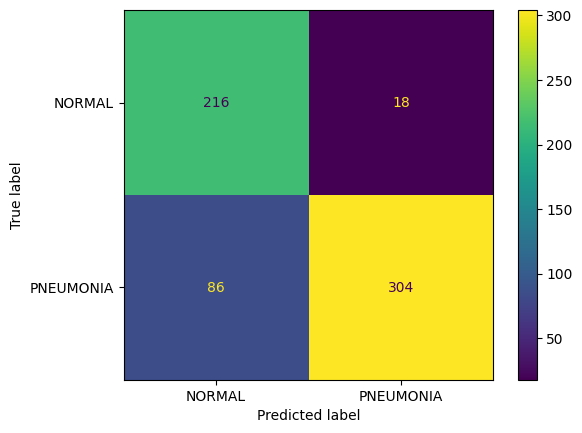

[{}]

In [39]:
# retrieve the best model from checkpoints
best_model_path = checkpoint_callback.best_model_path
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config, model=model)
pneumonia_model = best_model

# test the best model
trainer.test(pneumonia_model, datamodule=pneumonia_data)
#trainer.test(ckpt_path="best", datamodule=pneumonia_data) # alternatively, to test the best model directly

In [40]:
print(f"Test accuracy: {pneumonia_model.test_acc*100:.2f}%")
print(f"Precision: {pneumonia_model.test_precision*100:.2f}%")
print(f"Recall: {pneumonia_model.test_recall*100:.2f}%")
print(f"F1-score: {pneumonia_model.test_f1*100:.2f}%")

Test accuracy: 83.08%
Precision: 94.41%
Recall: 77.95%
F1-score: 85.39%


## Retrieve training loss and accuracy

In [42]:
# to retrieve train/val losses and accuracies
#ckpt = torch.load(checkpoint_path+"/last.ckpt")
#ckpt['callbacks']['PlotLearningCurvesCallback']

# to retrieve train/val losses and accuracies
pneumonia_model.train_outputs
pneumonia_model.val_outputs

{'train_losses': [array(0.4594303, dtype=float32),
  array(0.3024741, dtype=float32)],
 'train_accs': [array(83.653435, dtype=float32),
  array(89.52198, dtype=float32)],
 'val_losses': [array(0.41486093, dtype=float32),
  array(0.47439143, dtype=float32)],
 'val_accs': [array(88.49056, dtype=float32), array(76.98113, dtype=float32)]}